## Visualisation basics

In the previous notebook, we learnt how to retrieve data from the CDS and produce simple visualisations with **earthkit**. In the next example, we will learn how to further customise **earthkit-maps** visualisations using a few different kinds of CDS datasets.

As always, we start by importing earthkit:

In [1]:
import earthkit as ek

/Users/mavj/opt/miniconda3/envs/DEVELOP/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### A practical example - El Niño and La Niña comparison

Let's apply what we learnt in the previous notebook to a more practical example - comparing sea surface temperatures in the pacific between El Niño conditions, La Niña conditions and normal conditions.

Let's compare the El Niño of 1997 to the La Niña of 1998 - and also add in a more "normal" year (1993) for reference. The effects of El Niño often peak in December, so let's create a dictionary defining our different years and conditions:

In [2]:
YEARS = {
    1993: "Normal conditions",
    1997: "El Niño",
    1998: "La Niña",
}

This dictionary will be useful later for quickly matching the data we are about to retrieve to the conditions that each year represents.

We're also only interested in an area over the Pacific Ocean for our El Niño comparison. **earthkit** provides some useful utility objects which allow us to pass information like bounding box extents between components, without worrying about things like the order of our extents (which tends to be different in every different piece of software!).

Let's create a bounding box which spans from -20°S to 20°N, and 100°E (in the west!) to 60°W (in the east!).

In [3]:
bbox = ek.data.utils.bbox.BoundingBox(
    north=20,
    south=-20,
    east=-60,
    west=100,
)

#### Retrieving the data

Let's retrieve **ERA5 monthly mean sea surface temperature** for **December** in each of our years of interest. In order to reduce the amount of data we have to handle, we can also pass our `bbox` directly into the request payload:

In [4]:

# If you are using the pre-downloaded data then please set DOWNLOAD_FROM_CDS to False
#  and set the LOCAL_DATA_DIR to where you stored the data.
DOWNLOAD_FROM_CDS = True
LOCAL_DATA_DIR = "../test_data/"

if DOWNLOAD_FROM_CDS:
    data = ek.data.from_source(
        "cds", "reanalysis-era5-single-levels-monthly-means",
        {
            "product_type": "monthly_averaged_reanalysis",
            "variable": "sea_surface_temperature",
            "year": list(YEARS),
            "month": "12",
            "time": "00:00",
            "area": bbox,
        },
    )
    # # These commands were used to save the data files in our managed storage,
    # #  they are not required for the notebook to run, and your computer will cache the 
    # #  results so you don't have to download again
    # data.save(f'{LOCAL_DATA_DIR}/era5-sst-el-nino-1993-1997-1998.grib')
else:
    data = ek.data.from_source("file", f'{LOCAL_DATA_DIR}/era5-sst-el-nino-1993-1997-1998.grib')

We can use **earthkit** to quickly see how many 2-dimensional "fields" we have in our data, by using the `data.ls()` method:

In [5]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sst,surface,0,19931201,0,0,an,0,regular_ll
1,ecmf,sst,surface,0,19971201,0,0,an,0,regular_ll
2,ecmf,sst,surface,0,19981201,0,0,an,0,regular_ll


As expected, we have three fields of SST (sea surface temperature) for December of 1993, 1997 and 1998.

#### Visualising the data

For this particular example, we want to use a **visualisation style** which emphasises the differences that we want to hightlight in our data - namely, the areas in which sea surface temperature changes significantly between El Niño and La Niña conditions. To do this, we can create an **earthkit-maps `Style`** object, containing the colours, levels and units that we want to see on our visualisation.

In [6]:
style = ek.maps.styles.Style(
    colors="Spectral_r",  # this is a named matplotlib colormap
    levels=range(15, 33),
    units="celsius",
)

Now we can plot our data with our newly-created style:

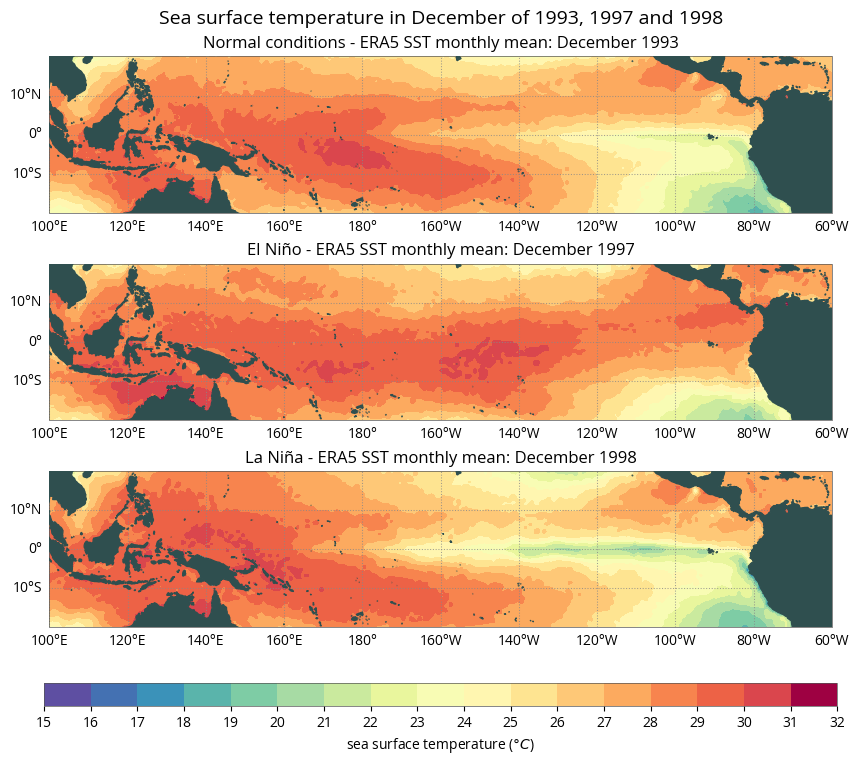

In [7]:
chart = ek.maps.Superplot(domain=bbox, rows=3)

chart.plot(data, style=style)  # this automatically converts data units to style units

chart.land(color="darkslategrey", zorder=10)
chart.gridlines(xlocs=range(-180, 180, 20), ylocs=range(-20, 20, 10))

for subplot, conditions in zip(chart, YEARS.values()):
    # Add a title to each subplot, using our convenient dictionary of conditions
    # to quickly add suitable titles
    # The !u conversion on short_name below converts to lower case
    subplot.title(f"{conditions} - ERA5 {{short_name!u}} monthly mean: {{time:%B %Y}}")

# Note that time can be formatted flexibly using datetime format keys - see
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
chart.title("{variable_name} in {time:%B} of {time:%Y}", fontsize=14)
    
chart.legend(label="{variable_name!l} ({units})", location="bottom", ticks=range(15, 33))
    
chart.show()

### Data on different projections

**earthkit** makes plotting data defined on different map projections simple and straightforward. By default, **earthkit-maps** will attempt to plot data *on its native projection* - you don't need to do anything special to make it understand your coordinate system (assuming you have all the correct metadata in the first place!).

For this example, let's retrieve some river discharge data from the European Flood Awareness System (EFAS) from the CDS, which is defined on a [Lambert Azimuthal Equal Area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) projection.

In [8]:
efas_data = ek.data.from_source(
    "cds", 
    "efas-historical",
    {
        'system_version': 'version_4_0',
        'variable': 'river_discharge_in_the_last_6_hours',
        'model_levels': 'surface_level',
        'hyear': '2023',
        'hmonth': '08',
        'hday': '10',
        'time': '12:00',
        'format': 'netcdf4.zip',
    },
)

As we did above for the ERA5 sea surface temperature data, we can use the `ls()` method to see how many unique 2-dimensional "fields" we've downloaded.

In [9]:
efas_data.ls()

,variable,level,time,units
0,dis06,None,None,m**3 s**-1
1,land_binary_mask,None,None,1
2,upArea,None,None,M2


EFAS river discharge data comes with a land binary mask and an upstream area field - but we're only interested in the river discharge data. We can select this unique field with the `sel()` method.

In [10]:
dis06 = efas_data.sel(variable="dis06")

Now that we've selected the data we're interested in, let's take a quick look at it with `ek.maps.quickplot`.

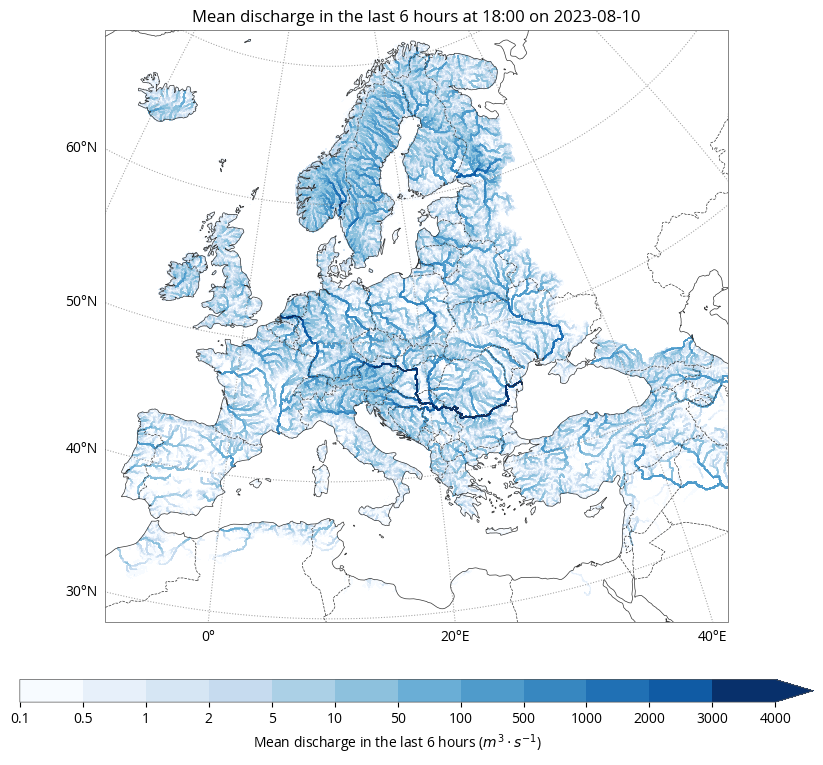

In [11]:
ek.maps.quickplot(dis06)

**earthkit-maps** was able to infer the projection from the EFAS metadata, and we've automatically got a plot on the data's native projection!

But what if we want a different projection? **earthkit-maps** uses the **cartopy** Python library to reproject data from an arbitrary source projection to one of [cartopy's built-in projections](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html). Take a look at the projections in the cartopy documentation and try changing the projection in the cell below (note that the resolution of the coastlines may change, as they attempt to react to the zoom level of the plot).

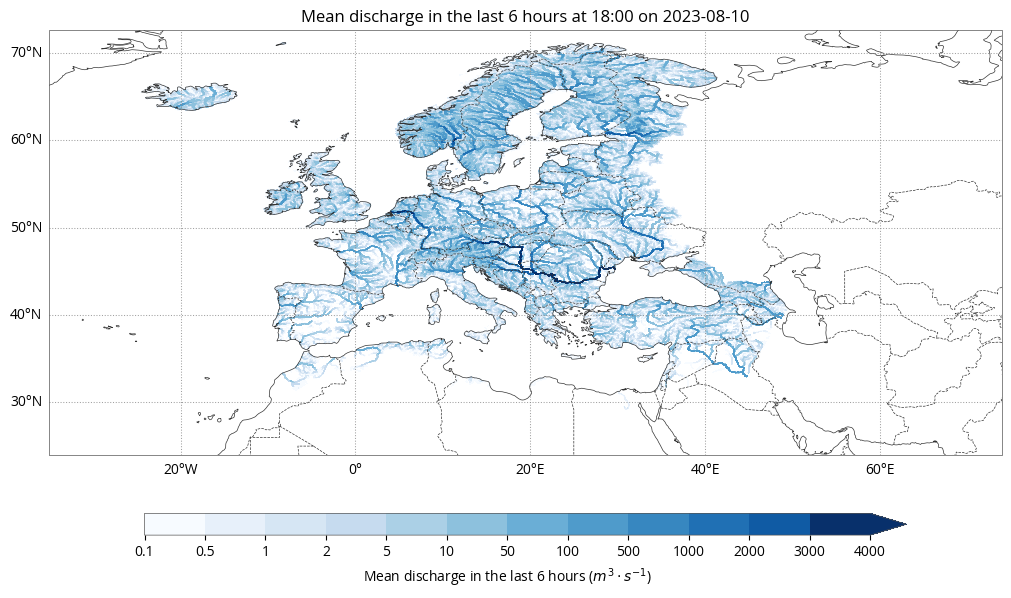

In [12]:
import cartopy.crs as ccrs

ek.maps.quickplot(dis06, crs=ccrs.PlateCarree())

### Data from other sources

So far we have only been accessing data from the CDS - but **earthkit** is compatible with data from a wide variety of sources (such as local files, URLs, ECMWF'S MARS archive, the CDS and more) and file formats (including netCDF, GRIB, CSV, GeoJSON and more).

For the next example, we will compare July 2023 temperature anomalies from the UK Met Office's [HADCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/) against ERA5, for the same reference period (1961-1990).

First, let's retrieve some HADCRUT5 data from the [HADCRUT5 download website](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html).

In [13]:
HADCRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/non-infilled/HadCRUT.5.0.1.0.anomalies.ensemble_mean.nc"
hadcrut5 = ek.data.from_source("url", HADCRUT5_URL)

Calling the `ls()` method shows that we have lots of variables and timesteps in this file:

In [14]:
hadcrut5.ls()

,variable,level,time,units
0,tas_mean,None,1850-01-16 12:00:00,K
1,tas_mean,None,1850-02-15 00:00:00,K
2,tas_mean,None,1850-03-16 12:00:00,K
3,tas_mean,None,1850-04-16 00:00:00,K
4,tas_mean,None,1850-05-16 12:00:00,K
...,...,...,...,...
4164,time_bnds,None,2023-06-16 00:00:00,None
4165,time_bnds,None,2023-07-16 12:00:00,None
4166,latitude_bnds,None,NaT,None
4167,longitude_bnds,None,NaT,None


Let's select the temprature data for July 2023.

In [15]:
from datetime import datetime
hadcrut5_anomaly = hadcrut5.sel(variable="tas_mean", time=datetime(2023, 7, 16, 12))

Now we need to retrieve ERA5 data for both the reference period (1961-1990) and July 2023.

In [16]:
era5_reference = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": list(range(1961, 1991)),
        "month": "07",
        "time": "00:00",
    },
)

era5_2023 = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": 2023,
        "month": "07",
        "time": "00:00",
    },
)

So far we have worked with the data and geospatial visualisation components of **earthkit**, but in order to calculate the ERA5 temperature anomalies we will need to do a bit of analysis. The **earthkit-climate** package provides some pre-configured functions for performing spatio-temporal aggregations, including anomalies - these tools will be explored in more detail in the next notebook, but for now, lets convert our reference period to a climatology and then calculate the anomnaly for July 2023.

In [17]:
era5_climatology = ek.climate.aggregate.climatology.mean(era5_reference, frequency="month")
era5_anomaly = ek.climate.aggregate.climatology.anomaly(era5_2023, era5_climatology, label=None, frequency="month")

Now we have some useable data from HADCRUT5 and ERA5, but before we plot these layers, let's create a nice anomaly style.

In [18]:
style = ek.maps.styles.Contour(
    colors=['#08306b', '#08519c', '#f9fbfd', '#fff7ec', '#e94b0d', '#7f0000'],
    levels=[-5, -3, 0, 0, 3, 5],
    gradients=[30, 90, 0, 90, 30],  # the number of bins between each level
    ticks=range(-5, 6),
    units="celsius",
)

No let's plot our data! This should all look quite familiar now, except that we are now calling `chart.pcolormesh` instead of `chart.plot`. This forces **earthkit** to use [matplotlib's `pcolormesh`](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjyrI2mo5iBAxXRU0EAHesBDuIQFnoECBEQAQ&url=https%3A%2F%2Fmatplotlib.org%2Fstable%2Fgallery%2Fimages_contours_and_fields%2Fpcolormesh_levels.html&usg=AOvVaw2cO3cAbK96cwAqCQHHAgbz&opi=89978449) visualisation technique, which will plot grid cells at the resolution of the data - which is recommended for low-resolution like HADCRUT5 with lots of gaps.

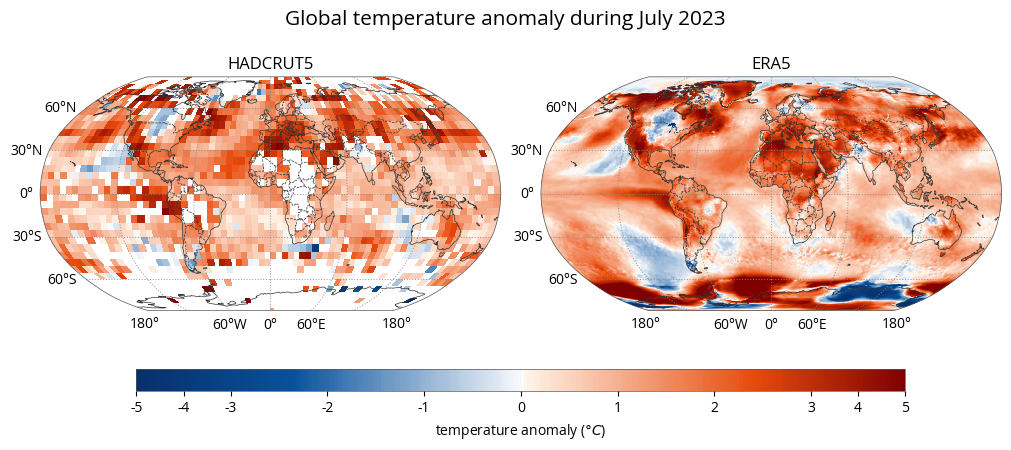

In [19]:
chart = ek.maps.Superplot(crs=ccrs.Robinson(), rows=1, cols=2)

chart.pcolormesh([hadcrut5_anomaly, era5_anomaly], style=style)

chart.coastlines()
chart.gridlines()
chart.borders()

chart.legend(label="temperature anomaly ({units})")

chart.subplot_titles(["HADCRUT5", "ERA5"])
chart.title("Global temperature anomaly during {time:%B %Y}", fontsize=15, y=0.575)

chart.show()

**earthkit-maps** provides an efficient and convenient way to quickly produce plots, but sometimes you might find that you need to do something more advanced or that isn't (yet) implemented. **earthkit-maps** is built on top of **matplotlib**, and all of the underlying **matplotlib** objects can be easily accessed from **earthkit-maps** charts.

For example, we can access the underlying matplotlib `Figure`:

In [20]:
type(chart.fig)

matplotlib.figure.Figure

And we can access the matplotlib `Axes` for each subplot:

In [21]:
type(chart[0].ax)

cartopy.mpl.geoaxes.GeoAxes

Armed with this knowledge, we can use some built-in **matplotlib** features to add advanced features to our maps.

Let's polish off our comparison plot by adding some shaded areas behind the HADCRUT5 data to show where the missing values are.

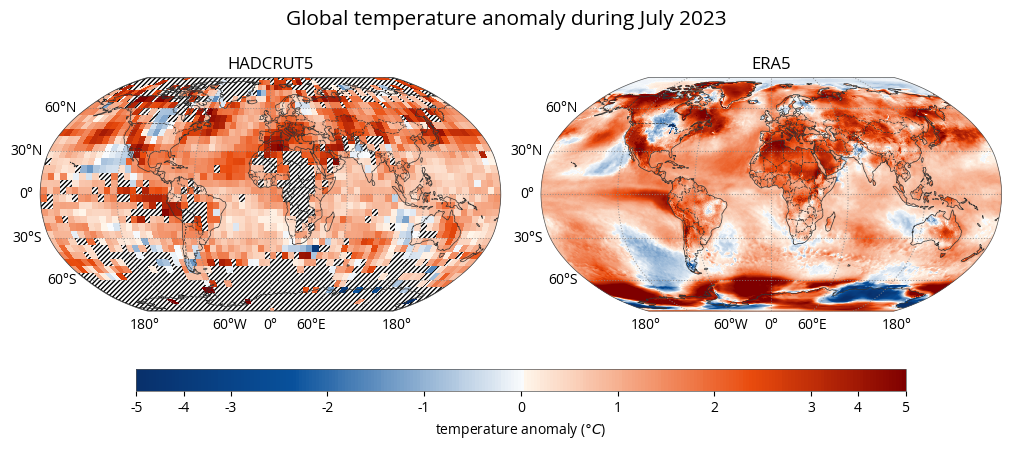

In [22]:
x = [-180, -180, 180, 180, -180]
y = [-90, 90, 90, -90, -90]

chart[0].ax.fill(x, y, transform=ccrs.PlateCarree(), hatch="///////", fill=False, zorder=0)
chart.fig